In [ ]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft

df = pd.read_csv('/content/20240708_104010_geophone_data.csv')

adc_values = df['Differential Value'].values

sampling_rate = 250
window_size = 60  # This is the window size

def create_windows(data, window_size):
    windows = [data[i:i + window_size] for i in range(0, len(data) - window_size + 1)]
    return windows

def zero_crossing_rate(signal):
    return np.mean(np.diff(np.sign(signal)) != 0)

def extract_frequency_domain_features(signal, sampling_rate):
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/sampling_rate)
    fft_values = np.abs(fft(signal))

    peak_freq = freqs[np.argmax(fft_values)]

    spectral_spread = np.sqrt(np.sum(((freqs - peak_freq) ** 2) * fft_values) / np.sum(fft_values))

    rms_energy = np.sqrt(np.mean(np.square(signal)))

    zcr = zero_crossing_rate(signal)

    return [peak_freq, spectral_spread, rms_energy, zcr]

windows = create_windows(adc_values, window_size)

frequency_features = [extract_frequency_domain_features(window, sampling_rate) for window in windows]

columns = ['Peak_Frequency', 'Spectral_Spread', 'RMS_Energy', 'Zero_Crossing_Rate']

features_df = pd.DataFrame(frequency_features, columns=columns)

features_csv_path = 'extracted_frequency_features_selected.csv'
features_df.to_csv(features_csv_path, index=False)

print(f"Features saved to: {features_csv_path}")


Features saved to: extracted_frequency_features_selected.csv


In [ ]:
import pandas as pd

df = pd.read_csv('/content/extracted_frequency_features_selected.csv')

def label_peak_frequency(row):
    if 10 <= row['Peak_Frequency'] <= 60:
        return 1
    else:
        return 0

df['Label'] = df.apply(label_peak_frequency, axis=1)

output_file_path = 'labeled_features.csv'
df.to_csv(output_file_path, index=False)

print(f"Updated CSV file saved as: {output_file_path}")


Updated CSV file saved as: labeled_features.csv


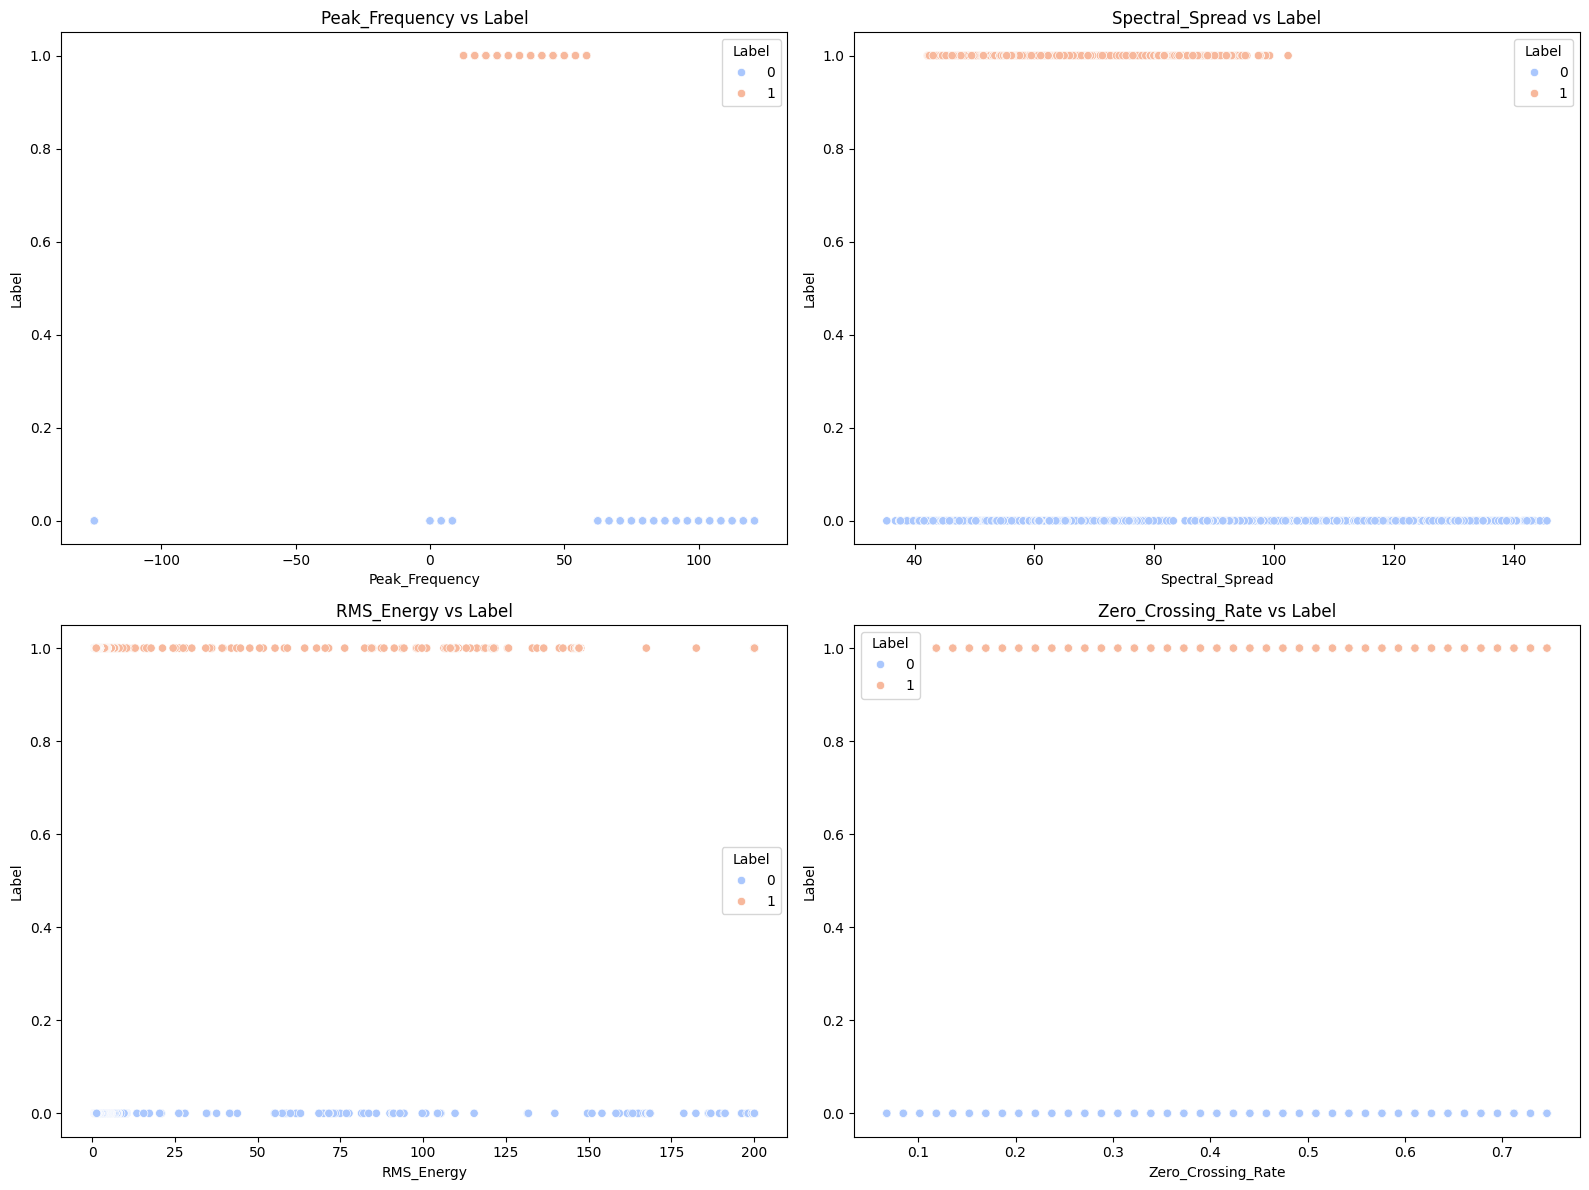

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/labeled_features.csv')

features = ['Peak_Frequency', 'Spectral_Spread', 'RMS_Energy', 'Zero_Crossing_Rate']

plt.figure(figsize=(16, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[feature], y=df['Label'], hue=df['Label'], palette='coolwarm')
    plt.title(f'{feature} vs Label')
    plt.xlabel(feature)
    plt.ylabel('Label')

plt.tight_layout()
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1208/1208 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7592 - loss: 0.5488 - val_accuracy: 0.9946 - val_loss: 0.1927
Epoch 2/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9560 - loss: 0.2044 - val_accuracy: 0.9950 - val_loss: 0.0649
Epoch 3/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9787 - loss: 0.0935 - val_accuracy: 0.9954 - val_loss: 0.0373
Epoch 4/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9850 - loss: 0.0593 - val_accuracy: 0.9966 - val_loss: 0.0276
Epoch 5/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9878 - loss: 0.0435 - val_accuracy: 0.9975 - val_loss: 0.0215
Epoch 6/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9910 - loss: 0.0324 - val_accuracy: 0.9969 - val_loss: 0.0175
Epoch 7/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9906 - loss: 0.0299 - val_accuracy: 0.9978 - val_loss: 0.0153
Epoch 8/10
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9937 - loss: 0.0228 - val_accurac

518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Accuracy: 99.82%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8254
           1       1.00      1.00      1.00      8306

    accuracy                           1.00     16560
   macro avg       1.00      1.00      1.00     16560
weighted avg       1.00      1.00      1.00     16560



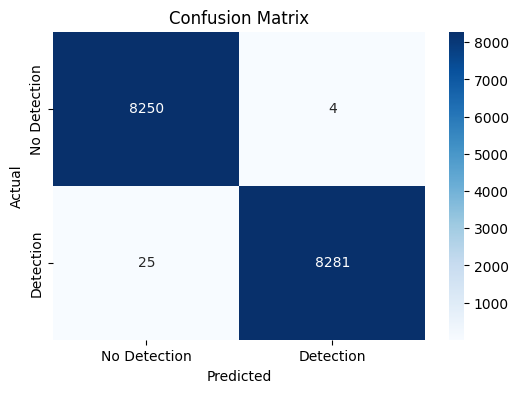

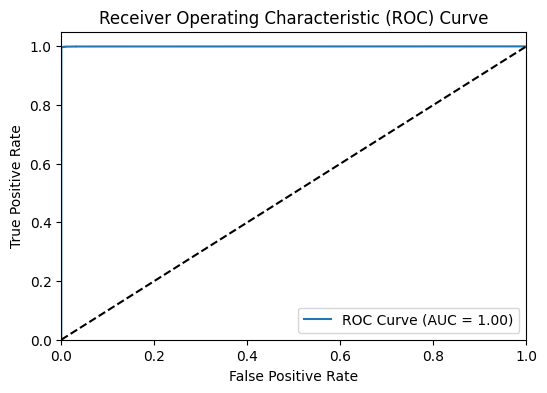

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score

df = pd.read_csv('/content/labeled_features.csv')

X = df.drop('Label', axis=1).values
y = df['Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

model = Sequential()

model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


model.save('dense_layer_model.h5')
joblib.dump(scaler, 'scaler.pkl')

y_pred_prob = model.predict(X_test)
threshold = 0.55
y_pred_new = (y_pred_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_new)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred_new)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_new)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Detection", "Detection"], yticklabels=["No Detection", "Detection"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
